# Tropical Cyclone Wind Return Period Maps

Notebook environment to migrate csv files to CF compliant zarr

In [112]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [113]:
# Import standard packages
import os
import pathlib
import sys

import numpy as np
#import geopandas as gpd
 
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import itertools
import json
import copy
from itertools import chain
from shapely import wkb
import scipy.io
import cartopy.crs as ccrs
import cartopy

# Import custom functionality
# sys.path.append('c:/Windows/System32/coclicodata/src')#CLENMAR ADDED

from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy

# Define (local and) remote drives
gca_data_dir = r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\01_Hazards\01_Present\Extreme_Tropical_Cyclone_Wind"
#gca_data_dir = p_drive.joinpath("11209197-018-global-coastal-atlas","MSc_students","ClenmarRowe")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    pathlib.Path().home().joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"AppData\Local\miniconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml" ###Changed from anaconda to miniconda  - added the new package udunits file
    )
)


<IPython.core.display.Javascript object>

In [114]:
# Project paths & files (manual input)
dataset_dir = pathlib.Path().joinpath(gca_data_dir,"PC_1000yrs_cat_3_4")
dataset_dir_path = dataset_dir.joinpath("Extreme_Tropical_Cyclone_Wind_original.nc")
CF_dir = dataset_dir.joinpath("CF")  # directory to save output CF check files
CF_dir

WindowsPath('P:/11209197-018-global-coastal-atlas/MSc_students/ClenmarRowe/Data/All_Datasets/Orig_Datasets/01_Hazards/01_Present/Extreme_Tropical_Cyclone_Wind/PC_1000yrs_cat_3_4/CF')

<IPython.core.display.Javascript object>

In [115]:
filename=dataset_dir.joinpath("PC_1000yrs_cat_3_4.mat")



# Load .mat file
mat = scipy.io.loadmat(filename)
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jun 10 12:40:21 2024',
 '__version__': '1.0',
 '__globals__': [],
 'parameters': array([[(array([[(array(['Return period (total)'], dtype='<U21'), array([[-124, -123, -122, ...,   11,   12,   13],
                        [-124, -123, -122, ...,   11,   12,   13],
                        [-124, -123, -122, ...,   11,   12,   13],
                        ...,
                        [-124, -123, -122, ...,   11,   12,   13],
                        [-124, -123, -122, ...,   11,   12,   13],
                        [-124, -123, -122, ...,   11,   12,   13]], dtype=int16), array([[ 2,  2,  2, ...,  2,  2,  2],
                        [ 3,  3,  3, ...,  3,  3,  3],
                        [ 4,  4,  4, ...,  4,  4,  4],
                        ...,
                        [67, 67, 67, ..., 67, 67, 67],
                        [68, 68, 68, ..., 68, 68, 68],
                        [69, 69, 69, ..., 69, 69, 69]], dtype=ui

<IPython.core.display.Javascript object>

In [116]:
cols=list(mat.keys())
cols,len(cols)

(['__header__', '__version__', '__globals__', 'parameters'], 4)

<IPython.core.display.Javascript object>

In [117]:
mat[cols[-1]][0][2][0][0][0][0],mat[cols[-1]][0][2][0][0][0][1]

(array(['Return period >96kts'], dtype='<U20'),
 array([[-124, -123, -122, ...,   11,   12,   13],
        [-124, -123, -122, ...,   11,   12,   13],
        [-124, -123, -122, ...,   11,   12,   13],
        ...,
        [-124, -123, -122, ...,   11,   12,   13],
        [-124, -123, -122, ...,   11,   12,   13],
        [-124, -123, -122, ...,   11,   12,   13]], dtype=int16))

<IPython.core.display.Javascript object>

In [118]:
RP_96kts=mat[cols[-1]][0][2][0][0][0]
RP_96kts

(array(['Return period >96kts'], dtype='<U20'), array([[-124, -123, -122, ...,   11,   12,   13],
       [-124, -123, -122, ...,   11,   12,   13],
       [-124, -123, -122, ...,   11,   12,   13],
       ...,
       [-124, -123, -122, ...,   11,   12,   13],
       [-124, -123, -122, ...,   11,   12,   13],
       [-124, -123, -122, ...,   11,   12,   13]], dtype=int16), array([[ 2,  2,  2, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 4,  4,  4, ...,  4,  4,  4],
       ...,
       [67, 67, 67, ..., 67, 67, 67],
       [68, 68, 68, ..., 68, 68, 68],
       [69, 69, 69, ..., 69, 69, 69]], dtype=uint8), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[  0,   0,  68, 138,   0]], dtype=uint8), array(['scalar'], dtype='<U6'))

<IPython.core.display.Javascript object>

In [119]:
lon_val=RP_96kts[1][0]

lat_val=[]
for i in RP_96kts[2]:
  lat_val.append(i[0])
lat_val=np.array(lat_val)

data=RP_96kts[3]

data_array = xr.DataArray(data, coords=[('latitude', lat_val),('longitude', lon_val) ], name='TC_RP_map_96kts_PC')
ds = xr.Dataset({'TC_RP_map_96kts_PC': data_array})
ds


<xarray.Dataset>
Dimensions:             (latitude: 68, longitude: 138)
Coordinates:
  * latitude            (latitude) uint8 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69
  * longitude           (longitude) int16 -124 -123 -122 -121 ... 10 11 12 13
Data variables:
    TC_RP_map_96kts_PC  (latitude, longitude) float64 nan nan nan ... nan nan

<IPython.core.display.Javascript object>

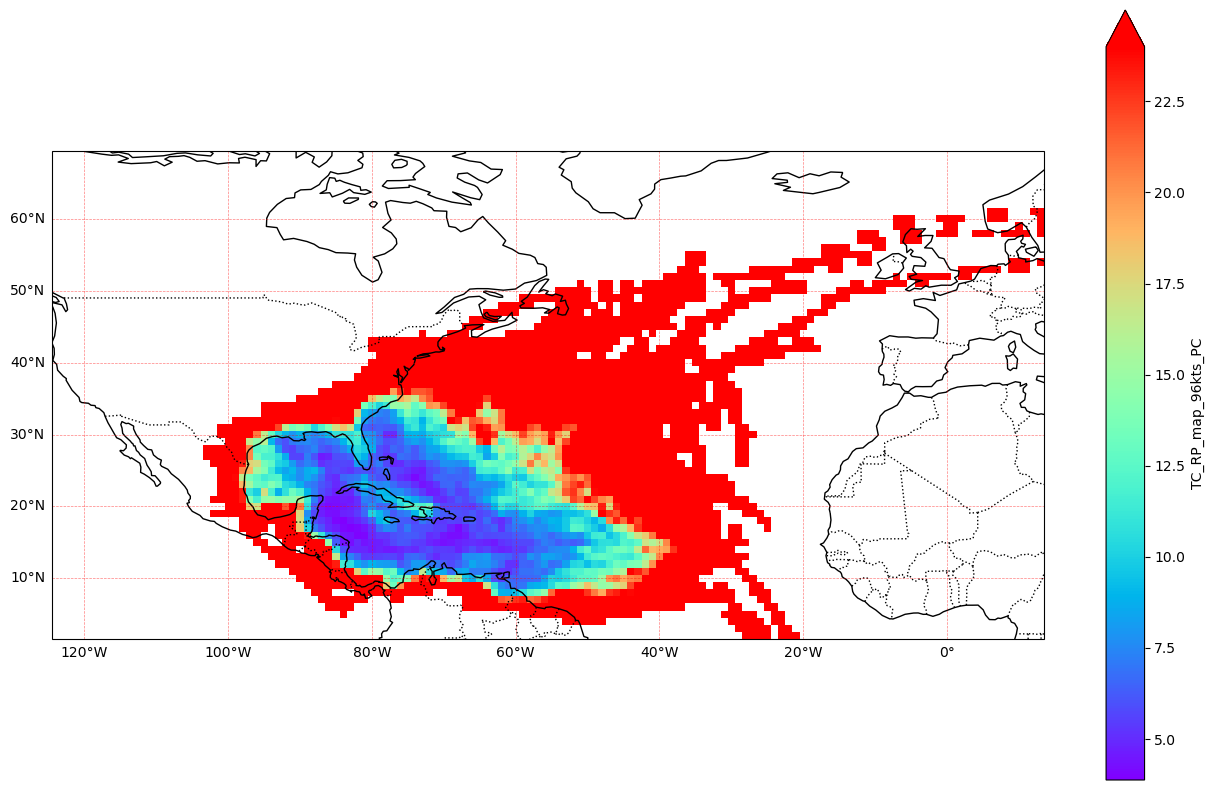

<IPython.core.display.Javascript object>

In [120]:
# ds["TC_RP_map_96kts_PC"].plot()

plt.figure(figsize=(16, 10))

# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
ds["TC_RP_map_96kts_PC"].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='rainbow', vmax=24)

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
# ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Set the title
# plt.title('Wave Height')

# Show the plot
plt.show()

In [121]:
#add future datasets

filename=dataset_dir.joinpath(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\01_Hazards\02_Future\Extreme_Tropical_Cyclone_Wind\FC_2100_RCP45_1000yrs_knutson\FC_2100_RCP45_1000yrs_knutson.mat")

# Load .mat file
mat = scipy.io.loadmat(filename)
RP_96kts=mat[cols[-1]][0][2][0][0][0]
print(RP_96kts[0])
data=RP_96kts[3]

ds["TC_RP_map_96kts_FC_2100_RCP45"] = (("latitude", "longitude"), data)
ds


['Return period >96kts']


<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 nan nan ... nan
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 nan nan ... nan

<IPython.core.display.Javascript object>

In [122]:
#add future datasets

filename=dataset_dir.joinpath(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\01_Hazards\02_Future\Extreme_Tropical_Cyclone_Wind\FC_2050_RCP85_1000yrs_Bloemendaal\FC_2050_RCP85_1000yrs_Bloemendaal.mat")

# Load .mat file
mat = scipy.io.loadmat(filename)
RP_96kts=mat[cols[-1]][0][2][0][0][0]
print(RP_96kts[0])
data=RP_96kts[3]

ds["TC_RP_map_96kts_FC_2050_RCP85"] = (("latitude", "longitude"), data)
ds


['Return period >96kts']


<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 nan nan ... nan
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 nan nan ... nan
    TC_RP_map_96kts_FC_2050_RCP85  (latitude, longitude) float64 nan nan ... nan

<IPython.core.display.Javascript object>

In [123]:
# Write the xarray dataset to a netCDF file
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

ds.to_netcdf(str(dataset_dir_path))

<IPython.core.display.Javascript object>

### Check CF compliancy original NetCDF files

In [124]:
# open datasets (only first file, rest is the same)
ds = xr.open_dataset(dataset_dir_path)

# check original dataset
ds

<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2050_RCP85  (latitude, longitude) float64 ...

<IPython.core.display.Javascript object>

In [125]:
%%capture cap --no-stderr
# check original CF compliancy (for first file)

check_compliancy(testfile=dataset_dir_path, 
                 working_dir=CF_dir
                 )

<IPython.core.display.Javascript object>

In [126]:
# save original CF compliancy (for first file)
save_compliancy(cap, testfile=dataset_dir_path, working_dir=CF_dir)

{'P:\\11209197-018-global-coastal-atlas\\MSc_students\\ClenmarRowe\\Data\\All_Datasets\\Orig_Datasets\\01_Hazards\\01_Present\\Extreme_Tropical_Cyclone_Wind\\PC_1000yrs_cat_3_4\\Extreme_Tropical_Cyclone_Wind_original.nc': {'warnings': '8', 'errors': '0'}}


<IPython.core.display.Javascript object>

### Make CF compliant alterations to the NetCDF files (dataset dependent)

In [127]:
# open datasets (only first file, rest is the same)
ds = xr.open_dataset(dataset_dir_path)

ds

<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2050_RCP85  (latitude, longitude) float64 ...

<IPython.core.display.Javascript object>

In [128]:
import json

# NetCDF attribute alterations by means of metadata template
metadata_json=dataset_dir.joinpath("metadata_Tropical_Cat3_RP_Wind_map.json")

f_global = open(metadata_json)
meta_global = json.load(f_global)


for attr_name, attr_val in meta_global.items():
    if attr_name == 'PROVIDERS':
        attr_val = json.dumps(attr_val)
    ds.attrs[attr_name] = attr_val

ds.attrs['Conventions'] = "CF-1.8"
ds

<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2050_RCP85  (latitude, longitude) float64 ...
Attributes: (12/21)
    TITLE:               TCWISE 1000year Generated category 3 Tropical cyclon...
    TITLE_ABBREVIATION:  Cat3_wind_map
    DESCRIPTION:         The dataset includes a return period wind map for wi...
    SHORT_DESCRIPTION:   present and f2050-2100 category 3 return period wind...
    INSTITUTION:         Deltares
    PROVIDERS:           {"name": "Deltares", "url": "https://www.deltares.nl...
    ...                  ...
    DOI:                 https://doi.org/10.5194/nhess-21-861-2021
    LONG_NAME:           PRESENT_PROJECTED_21ST_CENTURY__CAT3_WINDS
    UNITS:               Years
    COMMENT:             1 x 1 degree resolution
    CRS:                 EPSG:4326
    Conventions:         CF-1.8

<IPython.core.display.Javascript object>

In [129]:
# ds = ds.rename_dims({"index": "nstations"})

# ds

<IPython.core.display.Javascript object>

In [18]:

# # rename variables, if necessary
# ds = ds.rename_vars(
#        {"X": "lon", "Y": "lat"
#          #,"index":"nstations" }
#        }
#   )
# ds

<IPython.core.display.Javascript object>

In [19]:

# # set some data variables to coordinates to avoid duplication of dimensions in later stage
# ds = ds.set_coords(["lon", "lat"])

# ds

<xarray.Dataset>
Dimensions:                                                       (
                                                                   nstations: 9866)
Coordinates:
  * index                                                         (nstations) int64 ...
    lat                                                           (nstations) float64 ...
    lon                                                           (nstations) float64 ...
Dimensions without coordinates: nstations
Data variables: (12/15)
    atGTSR_POT_EXP_RP100_ZtoHs_ens1000_CMIP5_ww3_hs_19792005      (nstations) float64 ...
    atGTSR_POT_EXP_RP100_ZtoHs_ens1000_CMIP5_ww3_hs_end21C_RCP45  (nstations) float64 ...
    atGTSR_POT_EXP_RP100_ZtoHs_ens1000_CMIP5_ww3_hs_end21C_RCP85  (nstations) float64 ...
    atGTSR_POT_EXP_RP10_ZtoHs_ens1000_CMIP5_ww3_hs_19792005       (nstations) float64 ...
    atGTSR_POT_EXP_RP10_ZtoHs_ens1000_CMIP5_ww3_hs_end21C_RCP85   (nstations) float64 ...
    atGTSR_POT_EXP_RP20_ZtoHs_ens1000_CMIP5_ww3_hs_19792005       (nstations) float64 ...
    ...                                                            ...
    atGTSR_changes_RP100_Hs_hist_end21C_RCP85                     (nstations) float64 ...
    atGTSR_changes_RP10_Hs_hist_end21C_RCP85                      (nstations) float64 ...
    atGTSR_changes_RP20_Hs_hist_end21C_RCP85                      (nstations) float64 ...
    atGTSR_changes_RP50_Hs_hist_end21C_RCP85                      (nstations) float64 ...
    Meucci_RP100_percent_change_end21C_RCP45                      (nstations) float64 ...
    Meucci_RP100_percent_change_end21C_RCP85                      (nstations) float64 ...
Attributes: (12/21)
    TITLE:               Projected 21st Century Changes in Extreme Wind-Wave ...
    TITLE_ABBREVIATION:  pwciewwe
    DESCRIPTION:         This study projects changes in extreme wind-wave eve...
    SHORT_DESCRIPTION:   Forecasting extreme wind-wave events for the 21st ce...
    INSTITUTION:         Australian Research Council, Commonwealth National E...
    PROVIDERS:           {"name": "CSIRO", "url": "https://doi.org/10.4225/08...
    ...                  ...
    DOI:                 https://doi.org/10.1126/sciadv.aaz7295
    LONG_NAME:           PROJECTED_21ST_CENTURY_CHANGES_IN_EXTREME_WIND-WAVE_...
    UNITS:               wave height in m
    COMMENT:             PLEASE DO NOT USE WITHOUT PERMISSION FROM THE AUTHOR...
    CRS:                 EPSG:4326
    Conventions:         CF-1.8

<IPython.core.display.Javascript object>

In [130]:
# #Drop index from coordinates list
# # ds=ds.rename_dims({"index": "nstations"})
# ds=ds.drop_vars("index")
# # ds = ds.set_coords(["error_code"])

ds

<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2050_RCP85  (latitude, longitude) float64 ...
Attributes: (12/21)
    TITLE:               TCWISE 1000year Generated category 3 Tropical cyclon...
    TITLE_ABBREVIATION:  Cat3_wind_map
    DESCRIPTION:         The dataset includes a return period wind map for wi...
    SHORT_DESCRIPTION:   present and f2050-2100 category 3 return period wind...
    INSTITUTION:         Deltares
    PROVIDERS:           {"name": "Deltares", "url": "https://www.deltares.nl...
    ...                  ...
    DOI:                 https://doi.org/10.5194/nhess-21-861-2021
    LONG_NAME:           PRESENT_PROJECTED_21ST_CENTURY__CAT3_WINDS
    UNITS:               Years
    COMMENT:             1 x 1 degree resolution
    CRS:                 EPSG:4326
    Conventions:         CF-1.8

<IPython.core.display.Javascript object>

In [131]:
# add or change certain variable / coordinate attributes
### dataset attributes is a dictionary of dictionaries
dataset_attributes = {
    "longitude": {"standard_name": "longitude", "long_name": "longitude", "units": "degrees_east"},
    "latitude": {"standard_name": "latitude", "long_name": "latitude", "units": "degrees_north"},
    "TC_RP_map_96kts_PC": {"long_name": "Present_Climate_Return_period_for_CAT3_Hurricane", "units": "1"}, # set to 1 if no unit
    "TC_RP_map_96kts_FC_2100_RCP45": {"long_name": "Future_Climate_2100_Return_period_for_CAT3_Hurricane", "units": "1"}, # set to 1 if no unit
    "TC_RP_map_96kts_FC_2050_RCP85": {"long_name": "Present_Climate_2050_Return_period_for_CAT3_Hurricane", "units": "1"}, # set to 1 if no unit


}  # specify custom (CF convention) attributes

 # add / overwrite attributes
for k, v in dataset_attributes.items():
    try:
        ds[k].attrs = dataset_attributes[k]
    except:
        continue
ds

<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2050_RCP85  (latitude, longitude) float64 ...
Attributes: (12/21)
    TITLE:               TCWISE 1000year Generated category 3 Tropical cyclon...
    TITLE_ABBREVIATION:  Cat3_wind_map
    DESCRIPTION:         The dataset includes a return period wind map for wi...
    SHORT_DESCRIPTION:   present and f2050-2100 category 3 return period wind...
    INSTITUTION:         Deltares
    PROVIDERS:           {"name": "Deltares", "url": "https://www.deltares.nl...
    ...                  ...
    DOI:                 https://doi.org/10.5194/nhess-21-861-2021
    LONG_NAME:           PRESENT_PROJECTED_21ST_CENTURY__CAT3_WINDS
    UNITS:               Years
    COMMENT:             1 x 1 degree resolution
    CRS:                 EPSG:4326
    Conventions:         CF-1.8

<IPython.core.display.Javascript object>

In [132]:
# Write the xarray dataset to a netCDF file
#Compliant netcdf
dataset_dir_path_CF=str(dataset_dir_path).replace("original","final")


ds.to_netcdf(path=dataset_dir_path_CF)

<IPython.core.display.Javascript object>

### Check CF compliancy modified NetCDF files

In [133]:
# open datasets (only first file, rest is the same)
ds = xr.open_dataset(dataset_dir_path_CF)

# check original dataset
ds

<xarray.Dataset>
Dimensions:                        (latitude: 68, longitude: 138)
Coordinates:
  * latitude                       (latitude) uint8 2 3 4 5 6 ... 65 66 67 68 69
  * longitude                      (longitude) int16 -124 -123 -122 ... 11 12 13
Data variables:
    TC_RP_map_96kts_PC             (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2100_RCP45  (latitude, longitude) float64 ...
    TC_RP_map_96kts_FC_2050_RCP85  (latitude, longitude) float64 ...
Attributes: (12/21)
    TITLE:               TCWISE 1000year Generated category 3 Tropical cyclon...
    TITLE_ABBREVIATION:  Cat3_wind_map
    DESCRIPTION:         The dataset includes a return period wind map for wi...
    SHORT_DESCRIPTION:   present and f2050-2100 category 3 return period wind...
    INSTITUTION:         Deltares
    PROVIDERS:           {"name": "Deltares", "url": "https://www.deltares.nl...
    ...                  ...
    DOI:                 https://doi.org/10.5194/nhess-21-861-2021
    LONG_NAME:           PRESENT_PROJECTED_21ST_CENTURY__CAT3_WINDS
    UNITS:               Years
    COMMENT:             1 x 1 degree resolution
    CRS:                 EPSG:4326
    Conventions:         CF-1.8

<IPython.core.display.Javascript object>

In [134]:
%%capture cap --no-stderr
# check original CF compliancy (for first file)

check_compliancy(testfile=dataset_dir_path_CF, 
                 working_dir=CF_dir
                 )

<IPython.core.display.Javascript object>

In [135]:
# save original CF compliancy (for first file)
save_compliancy(cap, testfile=dataset_dir_path_CF, working_dir=CF_dir)

{'P:\\11209197-018-global-coastal-atlas\\MSc_students\\ClenmarRowe\\Data\\All_Datasets\\Orig_Datasets\\01_Hazards\\01_Present\\Extreme_Tropical_Cyclone_Wind\\PC_1000yrs_cat_3_4\\Extreme_Tropical_Cyclone_Wind_final.nc': {'warnings': '0', 'errors': '0'}}


<IPython.core.display.Javascript object>

In [136]:
# export to zarr in write mode (to overwrite if exists)
ds.to_zarr(str(dataset_dir_path).replace("original","final").replace(".nc", ".zarr"), mode="w")

<IPython.core.display.Javascript object>